In [1]:
import Pkg; Pkg.activate(@__DIR__);

  Activating project at `~/Documents/eth_courses/notebooks/control/invariance`


In [140]:
using Convex
using LinearAlgebra
using SCS
using GLMakie
using Polyhedra
using ControlSystems

GLMakie.activate!(inline=true)
lines = GLMakie.lines
lines! =GLMakie. lines!

lines! (generic function with 1 method)

## Vertex representation

In [3]:
# problem data
n = 2;
px = [0 .5 2 3 1];
py = [0 1 1.5 .5 -.5];
m = size(px,2);

pxint = sum(px)/m; pyint = sum(py)/m;
px = [px px[1]];
py = [py py[1]];

In [4]:
# generate A,b
A = zeros(m,n); b = zeros(m,1);

for i=1:m
  A[i,:] = nullspace([px[i+1]-px[i] py[i+1]-py[i]])';
  b[i] = A[i,:]' * .5 * [px[i+1]+px[i]; py[i+1]+py[i]];
  if A[i,:]'*[pxint; pyint]-b[i]>0
    A[i,:] = -A[i,:];
    b[i] = -b[i];
  end
end

status:OPTIMALoptimal var[1.1565578250201032 0.17475051296630983; 0.17475051296927696 0.8105322136932249][1.343749973487608; 0.500000020136525;;]

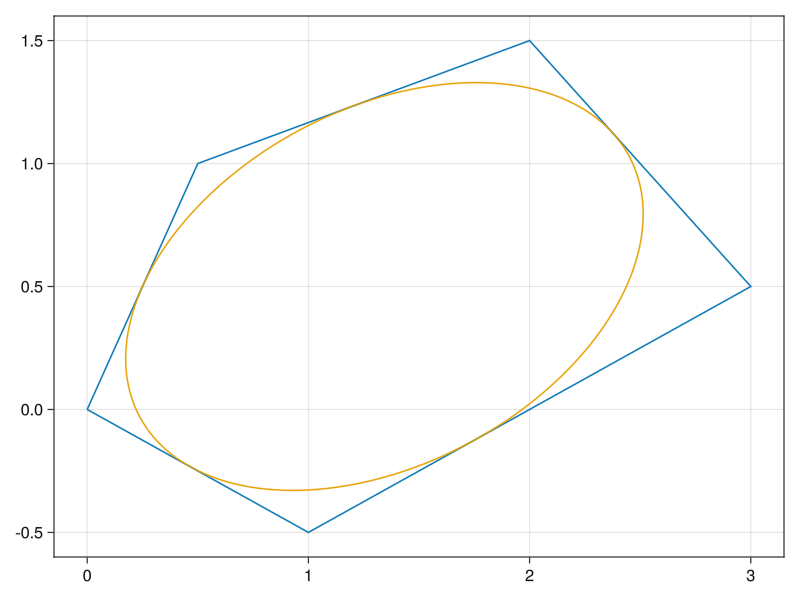

GLMakie.Screen(...)

In [8]:
# Create and solve the model
B = Semidefinite((n,n))
d = Variable((n,1))

prob = maximize(Convex.logdet(B))

constrs = []
for i=1:m
    prob.constraints += [Convex.norm( B*A[i,:], 2 ) + A[i,:]'*d <= b[i]]
end

solve!(prob, SCS.Optimizer; silent_solver = true)

print("status:", prob.status)
# print("optimal value", prob.value)
print("optimal var", B.value, d.value)


# make the plots
noangles = 200;
angles   = LinRange( 0, 2 * pi, noangles );
ellipse_inner  = B.value * [ cos.(angles)  sin.(angles) ]' + d.value * ones( 1, noangles );

fig = lines(vec(px), vec(py))
lines!(ellipse_inner[1,:], ellipse_inner[2,:])
display(fig)

## Halfspace representation

## Create controller

In [92]:
function get_halfspace(A,b)
    h = HalfSpace( A[1,:], b[1])

    for i in 2:length(b)
        h = h ∩ HalfSpace( A[i,:], b[i])
    end

    return h
end


get_halfspace (generic function with 1 method)

In [142]:
Ts = 0.1

A = [1.0 Ts; 0.0 1.0];
B = Matrix([Ts^2/2 Ts]');
C = [1 1]

Q = I(2)
R = 1000
K = lqr(Discrete,A,B,Q,R)

1×2 Matrix{Float64}:
 0.0312245  0.251841

## Constrints

In [183]:
# # Without controller
# A = [I(2); -2*I(2)]
# b = [1;2;0;0]

A = [I(2); -I(2); K; -K]
b = [1;1;1;1;0.1;0.1]

m = size(A,1);

h = get_halfspace(A,b)
poly_ = polyhedron(h)
poly_mesh = Polyhedra.Mesh(poly_) # use later for poltting

Polyhedra.Mesh{2, Float64, DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}}(HalfSpace([1.0, 0.0], 1.0) ∩ HalfSpace([0.0, 1.0], 1.0) ∩ HalfSpace([-1.0, 0.0], 1.0) ∩ HalfSpace([0.0, -1.0], 1.0) ∩ HalfSpace([0.03122454146674203, 0.251841328861442], 0.1) ∩ HalfSpace([-0.03122454146674203, -0.251841328861442], 0.1), nothing, nothing, nothing)

status:OPTIMAL
optimal var[0.9960580278956633 -0.08840809045090339; -0.08840809073798167 0.4063115930341487][3.739603279596733e-16; -4.410000416128313e-15;;]


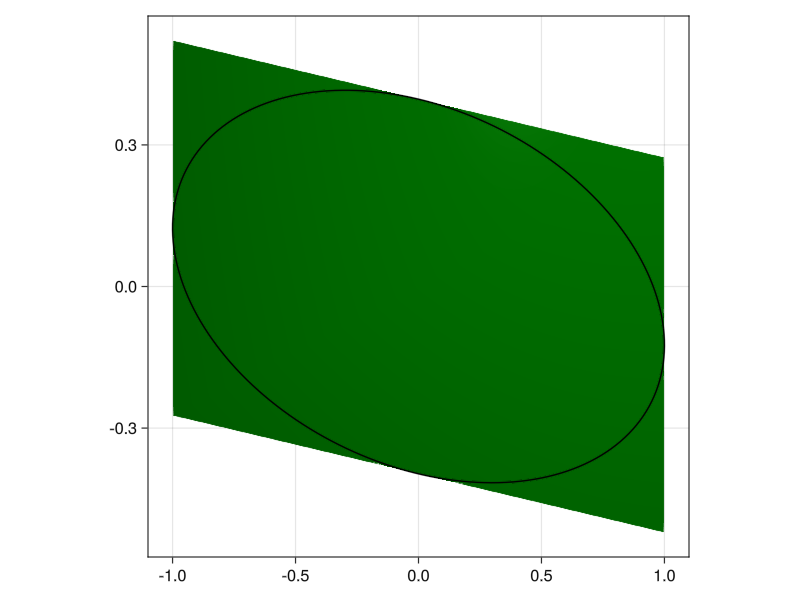

GLMakie.Screen(...)

In [184]:
# Create and solve the model
B = Semidefinite((n,n))
d = Variable((n,1))

prob = maximize(Convex.logdet(B))

constrs = []
for i=1:m
    prob.constraints += [Convex.norm( B*A[i,:], 2 ) + A[i,:]'*d <= b[i]]
end

solve!(prob, SCS.Optimizer; silent_solver = true)

println("status:", prob.status)
# print("optimal value", prob.value)
println("optimal var", B.value, d.value)


# make the plots
noangles = 200;
angles   = LinRange( 0, 2 * pi, noangles );
ellipse_inner  = B.value * [ cos.(angles)  sin.(angles) ]' + d.value * ones( 1, noangles );

fig = Figure()
ax = Axis(fig[1, 1], aspect=1)
mesh!(ax, poly_mesh, color=:green) # state constrains unser LQR control
lines!(ax, ellipse_inner[1,:], ellipse_inner[2,:], color=:black) # ellipsoid under LQR
display(fig) 